In [1]:
# imports for array-handling and plotting and time
import numpy as np
import time

import matplotlib
import matplotlib.pyplot as plt

# keras imports for the dataset and building neural network
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Conv2D, Flatten, MaxPooling2D
from keras.utils import np_utils, to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

# sklearn imports for model selection, data preparation and classifiers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

images = np.loadtxt("handwritten_digits_images.csv", delimiter=',')
labels = np.loadtxt("handwritten_digits_labels.csv", delimiter=',')

# Making sure that the values are float so that we can get decimal points after division
images = images.astype('float32')

# Normalizing the RGB codes by dividing it to the max RGB value.
images /= 255

X_train, X_test, y_train, y_test = train_test_split(images, labels,test_size=0.3, random_state=32)

#When we are not wrapping our nn into a KerasClassifier we need hot encoded y 
y_train_enc = np_utils.to_categorical(y_train, 10)
y_test_enc = np_utils.to_categorical(y_test, 10)

images1 = images[1::4]
labels1 = labels[1::4]

pca = IncrementalPCA(n_components=40, batch_size=100)
images_pca = pca.fit_transform(images1)

X_train3, X_test3, y_train3, y_test3 = train_test_split(images_pca, labels1,test_size=0.3, random_state=32)

Using TensorFlow backend.
/media/alessandro/storage/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
print()
print("---------------------- 1HiddenLayer NN --------------------------------------")
print()

def make_model1():
    
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))                            
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')    
    
    return model


def tuning1(X_train,Y_train,X_test,Y_test):

    batch_size = [50, 80, 100, 128, 135, 150]
    epochs = [15,20,25]
    param_grid = dict(batch_size=batch_size, nb_epoch=epochs)

    k_model = KerasClassifier(build_fn=make_model1, verbose=0)
   
    clf = GridSearchCV(estimator=k_model, param_grid=param_grid, 
                                   cv=3,
                                   scoring="accuracy", verbose=0 ,n_jobs=-1)
    clf.fit(X_train,Y_train)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    
    model=make_model1()
    
    return clf,model
  
tuning1_start = time.time()    
clf1 = tuning1(X_train,y_train,X_test,y_test)
tuning1_end = time.time()
print()
model1 = clf1[1]

fit1_start=time.time()
history1 = model1.fit(X_train,y_train_enc, batch_size=50, epochs=15 ,verbose=2,validation_data=(X_test, y_test_enc))
fit1_end=time.time()

#Evaluating the model
loss1, accuracy1 = model1.evaluate(X_test, y_test_enc, verbose=2)

print()
print("Test Loss : ", loss1)
print("Test Accuracy : ", round(accuracy1*100, 2), "%")
print("Cross Validation Time : ", round(tuning1_end-tuning1_start, 2), "sec" )
print("Training Time : ",  round(fit1_end-fit1_start, 2), "sec"  )


---------------------- 1HiddenLayer NN --------------------------------------

Best parameters set found on development set:

{'batch_size': 50, 'nb_epoch': 20}

Train on 49000 samples, validate on 21000 samples
Epoch 1/15
 - 5s - loss: 0.2508 - acc: 0.9270 - val_loss: 0.1417 - val_acc: 0.9597
Epoch 2/15
 - 5s - loss: 0.1098 - acc: 0.9669 - val_loss: 0.1038 - val_acc: 0.9683
Epoch 3/15
 - 5s - loss: 0.0766 - acc: 0.9766 - val_loss: 0.0828 - val_acc: 0.9750
Epoch 4/15
 - 5s - loss: 0.0585 - acc: 0.9816 - val_loss: 0.0890 - val_acc: 0.9733
Epoch 5/15
 - 5s - loss: 0.0442 - acc: 0.9860 - val_loss: 0.0756 - val_acc: 0.9778
Epoch 6/15
 - 5s - loss: 0.0360 - acc: 0.9883 - val_loss: 0.0812 - val_acc: 0.9755
Epoch 7/15
 - 5s - loss: 0.0311 - acc: 0.9900 - val_loss: 0.0740 - val_acc: 0.9780
Epoch 8/15
 - 5s - loss: 0.0260 - acc: 0.9918 - val_loss: 0.0722 - val_acc: 0.9789
Epoch 9/15
 - 5s - loss: 0.0252 - acc: 0.9914 - val_loss: 0.0745 - val_acc: 0.9805
Epoch 10/15
 - 5s - loss: 0.0192 - acc: 

In [2]:
#Taken from the history of the Keras' repo.
#Since Keras 2.0 metrics fmeasure, precision, and recall have been removed.

 
from keras import backend as K

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
print()
print("---------------------- Convolutional NN --------------------------------------")
print()

#reshape data to fit model
X_train_conv = X_train.reshape(49000,28,28,1)
X_test_conv = X_test.reshape(21000,28,28,1)

def make_model2():
    
    model = Sequential()

    model.add(Conv2D(10,kernel_size=5, activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(20, kernel_size=5, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1, precision, recall])  
    
    return model



def tuning2(X_train,Y_train,X_test,Y_test):

    
    epochs = list(range(1,5))
    param_grid = dict(nb_epoch=epochs)

    k_model = KerasClassifier(build_fn=make_model2, verbose=0)
   
    clf = GridSearchCV(estimator=k_model, param_grid=param_grid, 
                                   cv=5,
                                   scoring="accuracy", verbose=0 ,n_jobs=-1)
    clf.fit(X_train,Y_train)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    
    model=make_model2()
    
    return clf,model
    
tuning2_start = time.time()    
clf2 = tuning2(X_train_conv,y_train,X_test_conv,y_test)
tuning2_end = time.time()
tuning_time = tuning2_end-tuning2_start
print()
model2 = clf2[1]

fit2_start=time.time()
model2.fit(X_train_conv, y_train_enc, validation_data=(X_test_conv, y_test_enc), epochs=3)
fit2_end=time.time()
exec_time = fit2_end-fit2_start

#Evaluating the model
evaluation = model2.evaluate(X_test_conv, y_test_enc, verbose=2)

loss = evaluation[0]
accuracy = evaluation[1]
f1_measure = evaluation[2]
precision = evaluation[3]
recall = evaluation[4]

print()
print("Test Loss : ", loss)
print("Test Accuracy : ", round(accuracy*100, 2), "%")
print("F1-Measure", round(f1_measure, 4))
print("Precision", round(precision, 4))
print("Recall", round(recall, 4))
print("Cross Validation Time : ", round(tuning_time, 2), "sec" )
print("Training Time : ",  round(exec_time, 2), "sec"  )


predicted_classes = model2.predict_classes(X_test_conv)
conmat = confusion_matrix(y_test, predicted_classes)

print()
print('Confusion Matrix : ')
print()
print(conmat)
print()

# see which we predicted correctly and which not ----- Indices of elements that are non-zero.
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

error_rate = len(incorrect_indices)/(len(correct_indices)+len(incorrect_indices))

print()
print("Error rate : ", round(error_rate*100, 2), "%")


---------------------- Convolutional NN --------------------------------------

Best parameters set found on development set:

{'nb_epoch': 3}

Train on 49000 samples, validate on 21000 samples
Epoch 1/3
49000/49000 [==============================] - 16s 327us/step - loss: 0.2722 - acc: 0.9164 - f1: 0.9019 - precision: 0.9280 - recall: 0.8853 - val_loss: 0.0983 - val_acc: 0.9710 - val_f1: 0.9712 - val_precision: 0.9760 - val_recall: 0.9666
Epoch 2/3
49000/49000 [==============================] - 16s 322us/step - loss: 0.0985 - acc: 0.9709 - f1: 0.9712 - precision: 0.9756 - recall: 0.9669 - val_loss: 0.0665 - val_acc: 0.9800 - val_f1: 0.9801 - val_precision: 0.9827 - val_recall: 0.9776
Epoch 3/3
49000/49000 [==============================] - 16s 322us/step - loss: 0.0738 - acc: 0.9776 - f1: 0.9779 - precision: 0.9809 - recall: 0.9751 - val_loss: 0.0623 - val_acc: 0.9819 - val_f1: 0.9822 - val_precision: 0.9840 - val_recall: 0.9805

Test Loss :  0.062291610156230276
Test Accuracy :  98.

In [5]:
print()
print("---------------------- K-NN Classifier --------------------------------------")
print()

KnnClassifier=KNeighborsClassifier()

grid_params = {"n_neighbors": range(1, 10)}

tuning3_start = time.time()    
grid_search = GridSearchCV(KnnClassifier, grid_params, verbose=0, n_jobs=-1)
tuning3_end = time.time()

fit3_start=time.time()
grid_search.fit(X_train3, y_train3)
fit3_end=time.time()

predicted = grid_search.predict(X_test3)
acc = accuracy_score(y_test3, predicted)

print()
print("Best parameters set found on development set:")
print()
print(grid_search.best_params_)

print()
print("Test Accuracy : ", round(acc*100, 2), "%")
print("Cross Validation Time : ", round(tuning3_end-tuning3_start, 2), "sec" )
print("Training Time : ",  round(fit3_end-fit3_start, 2), "sec"  )



---------------------- K-NN Classifier --------------------------------------


Best parameters set found on development set:

{'n_neighbors': 3}

Test Accuracy :  96.34 %
Cross Validation Time :  0.0 sec
Training Time :  42.37 sec


In [2]:
print()
print("---------------------- RandomForest Classifier --------------------------------------")
print()

rfc = RandomForestClassifier(n_jobs=-1)

grid_params1 = {"n_estimators": range(1, 20)}

tuning4_start = time.time()    
grid_search1 = GridSearchCV(rfc, grid_params1, verbose=0, n_jobs=-1)
tuning4_end = time.time()

fit4_start=time.time()
grid_search1.fit(X_train, y_train)
fit4_end=time.time()

predicted1 = grid_search1.predict(X_test)
acc1 = accuracy_score(y_test, predicted1)

print()
print("Best parameters set found on development set:")
print()
print(grid_search1.best_params_)

print()
print("Test Accuracy : ", round(acc1*100, 2), "%")
print("Cross Validation Time : ", round(tuning4_end-tuning4_start, 2), "sec" )
print("Training Time : ",  round(fit4_end-fit4_start, 2), "sec"  )


---------------------- RandomForest Classifier --------------------------------------


Best parameters set found on development set:

{'n_estimators': 19}

Test Accuracy :  95.67 %
Cross Validation Time :  0.0 sec
Training Time :  36.1 sec


Feature ranking:
1. feature 433 (0.011760)
2. feature 378 (0.010729)
3. feature 542 (0.009558)
4. feature 350 (0.009426)
5. feature 483 (0.008373)
6. feature 377 (0.007779)
7. feature 434 (0.007545)
8. feature 211 (0.007334)
9. feature 517 (0.007316)
10. feature 461 (0.007304)
11. feature 515 (0.007208)
12. feature 351 (0.007084)
13. feature 210 (0.006836)
14. feature 569 (0.006727)
15. feature 381 (0.006589)
16. feature 262 (0.006499)
17. feature 153 (0.006455)
18. feature 488 (0.006391)
19. feature 346 (0.006250)
20. feature 291 (0.006194)
21. feature 429 (0.006176)
22. feature 156 (0.006132)
23. feature 375 (0.006009)
24. feature 183 (0.005926)
25. feature 354 (0.005916)
26. feature 486 (0.005837)
27. feature 624 (0.005676)
28. feature 297 (0.005670)
29. feature 490 (0.005540)
30. feature 430 (0.005525)
31. feature 657 (0.005433)
32. feature 572 (0.005421)
33. feature 464 (0.005406)
34. feature 348 (0.005364)
35. feature 318 (0.005343)
36. feature 290 (0.005320)
37. feature 410 (0.0

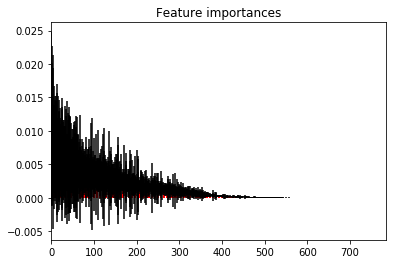

In [3]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=19,
                              random_state=32)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xlim([-1, X_train.shape[1]])
plt.show()